In [1]:
!pip install easyocr
!pip install imutils

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import easygui
import imutils
import easyocr
from IPython.display import Markdown, display

In [3]:
def read_in_image():
    """
    Function that reads a user selected image
    :return: image that was selected
    """
    easygui.msgbox(
        "Select an image with a registration plate to begin...",
        title="License Plate Extractor",
        ok_button="Select Image")

    # Read in the image
    return cv2.imread(easygui.fileopenbox())

In [4]:
def edge_detection(img):
    """
    Function that detects edges in an image
    :param img: Takes in original user selected image
    :return: image with highlighted edges and a grayscale version of the original image
    """
    
    # Parameters for bilateral filter and canny functions
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pixel_diameter = 11
    sigmaColor, sigmaSpace = 17, 17
    threshold1 = 30
    threshold2 = 200
    
    # Apply bilateral filter
    filtered_image = cv2.bilateralFilter(gray, pixel_diameter, sigmaColor, sigmaSpace)  # Noise reduction
    
    # Detecting edges in the image
    edged = cv2.Canny(filtered_image, threshold1, threshold2)

    return edged, gray

In [5]:
def find_contours(edged_image):
    """
    Function to detect contours from the provided edged image
    :param edged_image: Image with highlighted edges
    :return: Sorted contours array
    """
    
    # Locate contours in the edged image
    contours = cv2.findContours(edged_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    
    # return the sorted array of contours
    return sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [6]:
def identify_polygonal_curves(contours):
    """
    Function that detects polygonal curves in the contoured image
    :param contours: Contoured image
    :return: Location of the polygonal curves where length of it is 4 (e.g square or rectangle)
    """
    
    # Iterate through sorted array of contours and detect polygonal curves
    for contour in contours:
        polygonal_curves = cv2.approxPolyDP(contour, 10, True)
        
        # Break out of loop if there are 4 polygonal curves 
        if len(polygonal_curves) == 4:
            polygonal_loc = polygonal_curves
            break
    return polygonal_loc

## Example of how polygons are obtained:
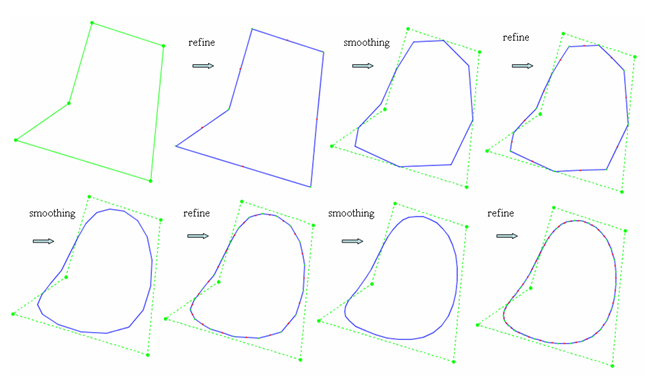

In [7]:
def identify_and_mask_contours(location, gray, img):
    """
    Function that identifies contours and creates a mask from it
    :param location: location array which contains the polygonal curves (forming rectangle)
    :param gray: grayscale version of originally selected image
    :param img: original image selected by user
    :return: reverse mask of the contoured image
    """
    
    # Get the dimensions of the gray image
    h, w = gray.shape
    
    # Create a mask
    mask = np.zeros((h, w), np.uint8)
    
    # Draw contours on the masked image and inverse it
    reg_plate_contoured = cv2.drawContours(mask, [location], 0, 255, -1)
    reg_plate_contoured = cv2.bitwise_and(img, img, mask=mask)
    return mask, reg_plate_contoured

In [8]:
def extract_x_y(mask, gray):
    """
    Function that locates the coordinates of the contoured registration plate
    :param mask: masked image
    :param gray: grayscale version of original image
    :return: cropped registration plate in grayscale
    """
    white_pixels = mask == 255

    x, y = np.where(white_pixels)
    x1 = y1 = float("inf")
    x2 = y2 = 0

    # Get the lowest x1, x2 values
    for val in x:
        x1 = min(x1, val)
        x2 = max(x2, val)

    # Get the lowest y1, y2 values
    for val in y:
        y1 = min(y1, val)
        y2 = max(y2, val)

    return gray[x1:x2+1, y1:y2+1]

In [9]:
def extract_text_from_plate(cropped_image):
    """
    Extracts english text from the image using easyOCR library
    :param cropped_image: cropped license plate of the grayscaled image
    :return: license plate number as a string
    """
    
    # Read the text from the cropped license plate
    reg_plate_text = easyocr.Reader(['en']).readtext(cropped_image)
    
    # Iterate over the result and extract license plate text
    license_plate = ''
    for item in reg_plate_text:
        license_plate += str(item[1]) + ' '
    return license_plate

In [10]:
def draw_rect_text_on_img(img, license_plate, polygonal_curves):
    """
    Function that draws a rectangle around the license plate and the plate's number
    :param img: original image selected by user
    :param license_plate: registration plate number
    :param polygonal_curves:
    """
    
    # Arguments for drawing txt on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_location = (polygonal_curves[0][0][0], polygonal_curves[1][0][1])
    color = (0, 255, 0)  # Green font
    offset = 60

    rectangle_location = (polygonal_curves[0][0], polygonal_curves[2][0])

    # Draw a rectangle and text on the image where the license plate is located
    paint_image = cv2.rectangle(img, tuple(rectangle_location[0]), tuple(rectangle_location[1]), color, 5)
    paint_image = cv2.putText(img, text=license_plate, org=(text_location[0], text_location[1] + offset), fontFace=font, fontScale=1, color=color, thickness=2, lineType=cv2.LINE_AA)
    
    return img

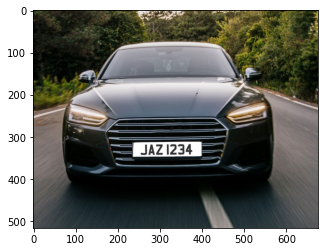

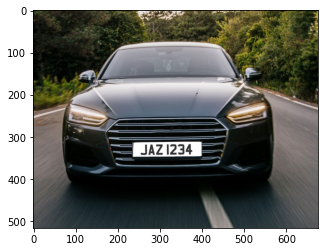

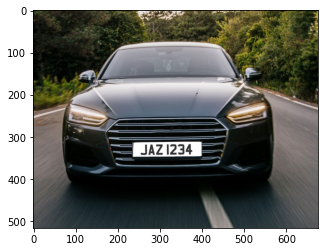

In [11]:
# Read in image
img = read_in_image()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

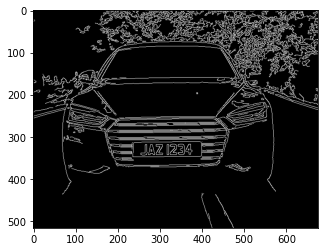

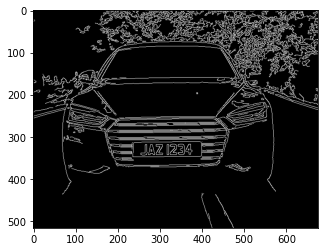

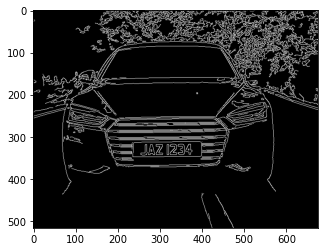

In [12]:
# Detect the edges in the image
edged_image, gray = edge_detection(img)
plt.imshow(cv2.cvtColor(edged_image, cv2.COLOR_BGR2RGB))

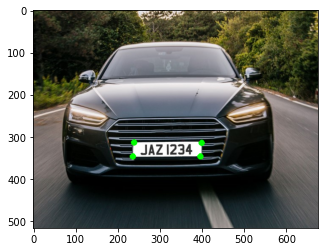

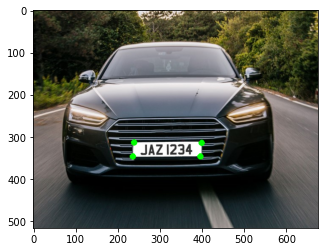

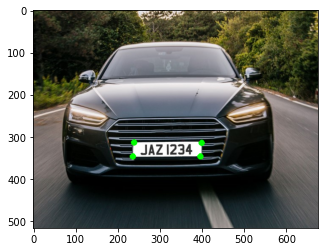

In [13]:
# Locate the contours in the edged image
contours = find_contours(edged_image)

# Identify the polygonal curves in the contour locations
polygonal_loc = identify_polygonal_curves(contours)

img_copy = img.copy()
for point in polygonal_loc:
    img_copy = cv2.circle(img_copy, (point[0][0], point[0][1]), radius=3, color=(0, 255, 0), thickness=7)

plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

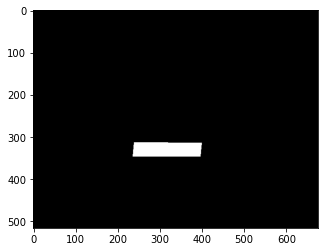

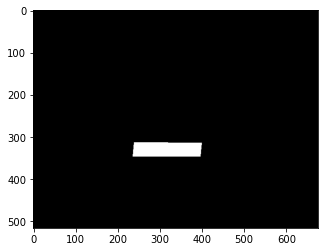

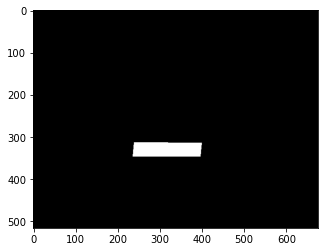

In [14]:
# Identify the contours, draw them and create a reverse mask
masked_img, reg_plate_contoured = identify_and_mask_contours(polygonal_loc, gray, img)
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))

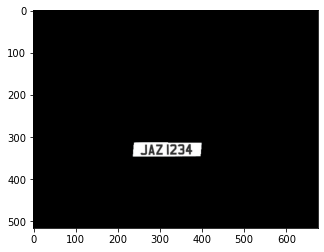

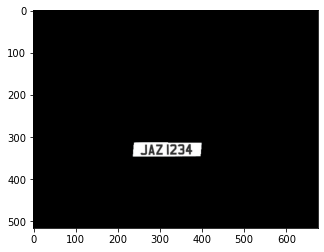

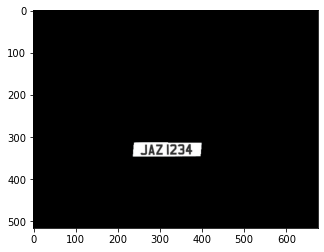

In [15]:
plt.imshow(cv2.cvtColor(reg_plate_contoured, cv2.COLOR_BGR2RGB))

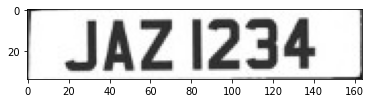

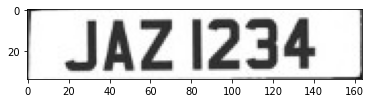

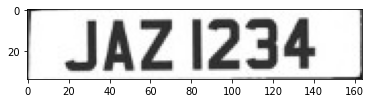

In [16]:
# Extract coordinates of the license plate and crop it
cropped = extract_x_y(masked_img, gray)
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

In [17]:
# Extract text from the cropped license plate
license_plate = extract_text_from_plate(cropped)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [18]:
display(Markdown('# Extracted License Plate: ' + str(license_plate)))

# Extracted License Plate: JAZ 1234 

# Extracted License Plate: JAZ 1234 

# Extracted License Plate: JAZ 1234 

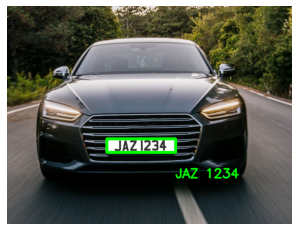

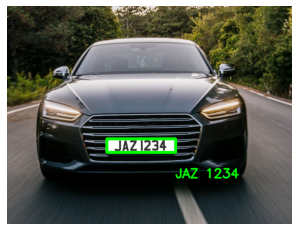

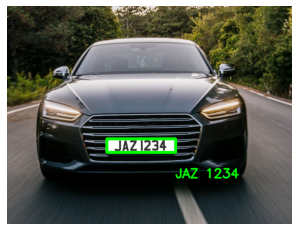

In [21]:
# Draw rectangle and license plate's contents onto the image
img = draw_rect_text_on_img(img, license_plate, polygonal_loc)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))